### Importering av bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spectral
from PIL import Image
import os
import glob
from ipywidgets import interact
import ipywidgets as widgets

### Funksjoner

In [2]:
def calibrate_wavelengths(ImageWidth, Spectral_lines, Pixel_positions, Degree, Output_file):
    """
    Calibrate pixel positions to wavelengths.

    Parameters:
    - ImageWidth: int, number of pixels.
    - Spectral_lines: list of float, spectral lines or known wavelengths in nm.
    - Pixel_positions: list of int, pixel positions corresponding to the known spectral lines.
    - Degree: int, degree of the polynomial fit (1 for linear).
    - Output_file: str, path to the output CSV file.

    Returns:
    - df: pandas DataFrame, containing pixel positions and calibrated wavelengths.
    """
    if len(Spectral_lines) != len(Pixel_positions):
        raise ValueError("The number of wavelengths must match the number of pixel positions.")
    if len(Spectral_lines) < 2:
        raise ValueError("At least two wavelengths and pixel positions are required for calibration.")

    # Fit a polynomial function to the known wavelengths at the pixel positions
    wavelength_fit = np.polyfit(Pixel_positions, Spectral_lines, Degree)
    wavelength_calibration = np.poly1d(wavelength_fit)

    # Calibrate the pixel positions to wavelengths
    calibrated_wavelengths = wavelength_calibration(np.arange(ImageWidth))

    # Create a DataFrame
    df = pd.DataFrame({
        'Pixel Position': np.arange(len(calibrated_wavelengths)),
        'Calibrated Wavelength (nm)': calibrated_wavelengths
    })

    # Save the DataFrame to a CSV file
    df.to_csv(Output_file, index=False)
    return df

def expected_irradiance(B_0):
    R = 0.92
    r_0 = 0.5 # from source to lambertian surface
    alpha = 0 # angle between source and normal to lambert
    p = 0.98 # diffusion coefficient of lambertian surface
    B_expected = B_0*(r_0/R)**2*p*np.cos(alpha) # photons/cm^2/s/Å

    return B_expected

def read_bip_file(file_path, width, height):
    with open(file_path, 'rb') as file:
        data = file.read()
    
    # Konverter binærdata til numpy array med 8-bit unsigned integers
    raw_data = np.frombuffer(data, dtype=np.uint8)
    
    # Kombiner 8-bit verdier til 16-bit verdier
    total_pixels = width * height
    pixel_data = np.zeros(total_pixels, dtype=np.uint16)
    
    for i in range(total_pixels):
        byte_index = i * 2
        pixel_data[i] = (raw_data[byte_index] << 8) | raw_data[byte_index + 1]
    
    # Reshape array til 2D bilde
    image = pixel_data.reshape((height, width))
    return image

def find_consecutive_range_means(arr):
    """
    Finds the mean of consecutive ranges in an array of integers.

    Parameters:
    - arr: numpy array of integers.

    Returns:
    - means: list of floats, each representing the mean of a consecutive range.
    """
    means = []
    start = arr[0]
    current_range = [start]
    
    for i in range(1, len(arr)):
        if arr[i] != arr[i-1] + 1:
            means.append(np.mean(current_range))
            current_range = [arr[i]]
        else:
            current_range.append(arr[i])
    
    # Append the mean of the last range
    means.append(np.mean(current_range))
    
    return means

### Bølgelengde Kalibrering

In [3]:
PixelWidth = 1936
PixelHeight = 1216

dark_paths_e50 = glob.glob(os.path.join('Data/dark-images/E50/', '*.bip')) # Eksponering 50 ms
dark_paths_e100 = glob.glob(os.path.join('Data/dark-images/E100/', '*.bip')) # Eksponering 100 ms
dark_paths_e300 = glob.glob(os.path.join('Data/dark-images/E300/', '*.bip')) # Eksponering 200 ms
dark_paths_e450 = glob.glob(os.path.join('Data/dark-images/E450/', '*.bip')) # Eksponering 450 ms
dark_paths_e500 = glob.glob(os.path.join('Data/dark-images/E500/', '*.bip')) # Eksponering 500 ms
dark_paths_e1000 = glob.glob(os.path.join('Data/dark-images/E1000/', '*.bip')) # Eksponering 1000 ms

H_paths = glob.glob(os.path.join('Data/H/', '*.bip')) # Eksponering 50 ms
He_paths = glob.glob(os.path.join('Data/HE/', '*.bip')) # Eksponering 30 ms
Hg_paths = glob.glob(os.path.join('Data/HG/', '*.bip')) # Eksponering 100 ms

In [21]:
img = read_bip_file(He_paths[0], PixelWidth, PixelHeight)

In [22]:
threshold = np.percentile(img, 99)  # Juster terskelen etter behov
spectral_lines = np.where(img > threshold)

unique_x_values = np.unique(spectral_lines[1])
spectralPeaks = find_consecutive_range_means(unique_x_values)
print("Spectral Peaks: ", spectralPeaks)

def plot_image(xline=0):
    plt.figure(figsize=(20, 14))
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.title('16-bit Image')
    plt.xticks(np.arange(0, PixelWidth, 100))
    plt.axvline(x=xline, color='red')  # Add vertical line at xline
    plt.show()

# Create interactive widget for x-coordinate
x_widget = widgets.IntSlider(min=0, max=img.shape[1]-1, step=1, description='X:')

# Use interact to create the interactive plot
interact(plot_image, xline=x_widget)

Spectral Peaks:  [16.5, 25.0, 58.0, 259.0, 300.0, 443.5, 551.0, 651.0, 723.0, 735.0, 909.5, 947.5, 1142.0, 1249.0, 1541.0, 1588.0, 1680.0, 1769.0, 1841.0, 1869.0]


interactive(children=(IntSlider(value=0, description='X:', max=1935), Output()), _dom_classes=('widget-interac…

<function __main__.plot_image(xline=0)>

In [27]:
Spectral_lines = [656.3, 486.1, 587.5, 667.8, 687.7, 436, 546] # 2 Hydrogen (H), 3 Helium (He), 2 Mercury (Hg)
pixel_positions = [909, 443, 720, 941, 1050, 306, 607]
degree = 2
output_file = 'Data/calibrated_wavelengths.csv'

df = calibrate_wavelengths(PixelWidth, Spectral_lines, pixel_positions, degree, output_file)
wavelengths = np.loadtxt(output_file, delimiter=',', skiprows=1, usecols=1)

### Intensitet Kalibrering

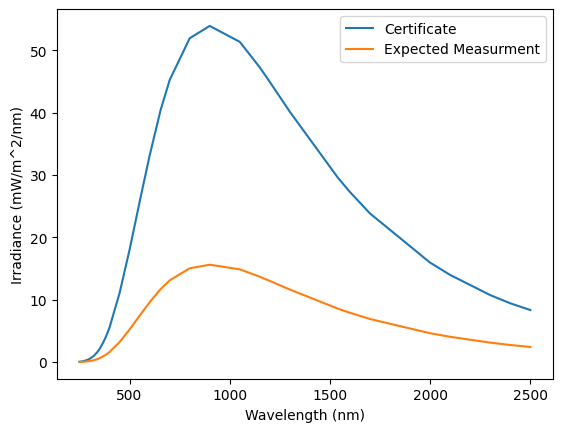

In [7]:
#Measured data
#B_measured = np.loadtxt('Data/measured.csv', delimiter=',', skiprows=1, usecols=1) # photons/cm^2/s/Å
#B_0 = np.loadtxt('Data/B0.csv', delimiter=',', skiprows=1, usecols=0) # photons/cm^2/s/Å

#Certificate data
W_L = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=0) # Wavelengths in nm
B_0 = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=1) # Irradiance in mW/m^2/nm
sigma = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=2) # Uncertainty in %


ImageHeight = 256

B_expected = expected_irradiance(B_0)

# plot B_0
plt.figure()
plt.plot(W_L,B_0, label='Certificate')
plt.plot(W_L,B_expected, label='Expected Measurment')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance (mW/m^2/nm)')
plt.legend()
plt.show()